In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install gdown

!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.8 MB/s eta 0:00:00


In [4]:
# Import the required libraries.
import os
import cv2

import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt


%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [5]:
seed_constant = 2
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [6]:
!unzip '/content/drive/MyDrive/Colab Notebooks/ShopDataSet.zip' -d '/content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip'

Archive:  /content/drive/MyDrive/Colab Notebooks/ShopDataSet.zip
replace /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/shop_lifter_n_0.mp4? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/shop_lifter_n_0.mp4  
  inflating: /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/shop_lifter_n_0_1.mp4  
  inflating: /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/shop_lifter_n_1.mp4  
  inflating: /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/shop_lifter_n_1_1.mp4  
  inflating: /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/shop_lifter_n_10.mp4  
  inflating: /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/shop_lifter_n_10_1.mp4  
  inflating: /content/drive/MyDrive/Col

In [7]:
all_classes_names = os.listdir('/content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet')
all_classes_names

['shop lifters', 'non shop lifters']

In [8]:
print('normal', len(os.listdir('/content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters')))
print('shoplifting', len(os.listdir('/content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/shop lifters')))

normal 531
shoplifting 324


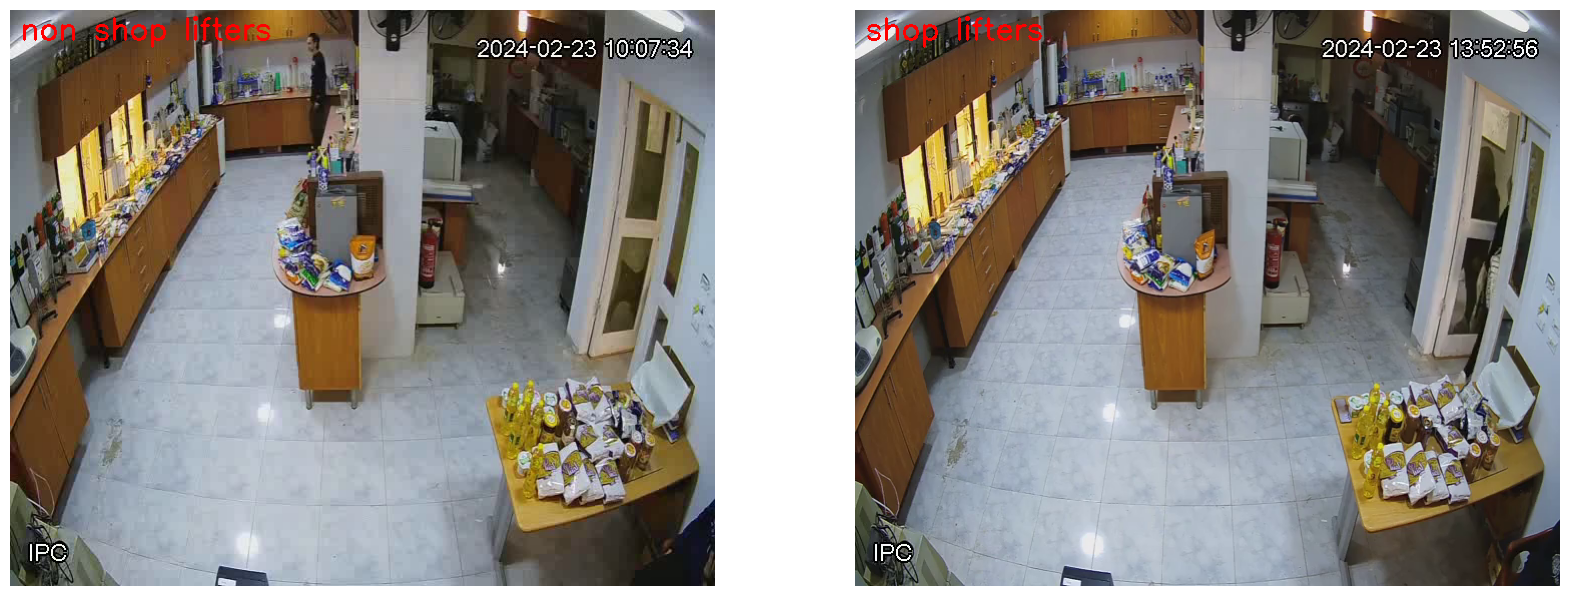

In [9]:
import os
import cv2
import matplotlib.pyplot as plt
import random

base_dir = '/content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet'

all_classes_names = ['non shop lifters', 'shop lifters']  # Define your classes explicitly

plt.figure(figsize=(20, 20))

random_range = random.sample(range(len(all_classes_names)), 2)

for counter, random_index in enumerate(random_range, 1):

    selected_class_name = all_classes_names[random_index]

    class_path = os.path.join(base_dir, selected_class_name)

    video_files_names_list = os.listdir(class_path)

    selected_video_file_name = random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(os.path.join(class_path, selected_video_file_name))

    success, bgr_frame = video_reader.read()

    video_reader.release()

    if success:
        rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

        cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        plt.subplot(1, 2, counter)
        plt.imshow(rgb_frame)
        plt.axis('off')  # Hide axes for better visualization
    else:
        print(f"Failed to read frame from video: {selected_video_file_name}")

plt.show()


In [10]:
IMAGE_HEIGHT , IMAGE_WIDTH = 80,80
SEQUENCE_LENGTH = 20
CLASSES_LIST = ['non shop lifters', 'shop lifters']

In [11]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)

    if not video_reader.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return frames_list

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total frames in video {video_path}: {video_frames_count}")

    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            print(f"Failed to read frame at {frame_counter * skip_frames_window} from {video_path}")
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list


In [12]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(base_dir, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(base_dir, class_name, file_name)
            frames = frames_extraction(video_file_path)

            print(f"Processed video: {video_file_path}, Frames extracted: {len(frames)}")

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
            else:
                print(f"Skipping video {file_name}: not enough frames ({len(frames)})")

    features = np.asarray(features)
    labels = np.array(labels)

    print(f"Total extracted features shape: {features.shape}")
    return features, labels, video_files_paths


In [13]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16764497677166777364
xla_global_id: -1
, name: "/device:TPU_SYSTEM:0"
device_type: "TPU_SYSTEM"
memory_limit: 8589934592
locality {
}
incarnation: 16853858840744434554
physical_device_desc: "device: TPU_SYSTEM device"
xla_global_id: -1
, name: "/device:TPU:0"
device_type: "TPU"
memory_limit: 17179869184
locality {
}
incarnation: 3739308748178192260
physical_device_desc: "device: TPU device"
xla_global_id: -1
, name: "/device:TPU:1"
device_type: "TPU"
memory_limit: 17179869184
locality {
}
incarnation: 1252871175078908752
physical_device_desc: "device: TPU device"
xla_global_id: -1
, name: "/device:TPU:2"
device_type: "TPU"
memory_limit: 17179869184
locality {
}
incarnation: 10303585855551354552
physical_device_desc: "device: TPU device"
xla_global_id: -1
, name: "/device:TPU:3"
device_type: "TPU"
memory_limit: 17179869184
locality {
}
incarnation: 17744015014264688072
physical_device_desc: "devi

In [14]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: non shop lifters
Total frames in video /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/shop_lifter_n_0.mp4: 450
Processed video: /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/shop_lifter_n_0.mp4, Frames extracted: 20
Total frames in video /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/shop_lifter_n_104_1.mp4: 350
Processed video: /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/shop_lifter_n_104_1.mp4, Frames extracted: 20
Total frames in video /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/shop_lifter_n_107.mp4: 175
Processed video: /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/shop_lifter_n_107.mp4, Frames extracted: 20
Total frames in video /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lift

In [ ]:
features.shape

In [15]:
one_hot_encoded_labels = to_categorical(labels)

In [16]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.3, shuffle = True,
                                                                            random_state = seed_constant)

In [18]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, GlobalAveragePooling2D, Dropout

In [20]:
# Pre-trained DenseNet121 for extracting features
def create_pretrained_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(80,80, 3))
    # Output a (7, 7, 1024) feature map per frame
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce dimensionality
    model = Model(inputs=base_model.input, outputs=x)

    return model


In [23]:
CATEGORIES = ["non shop lifters", "shop lifters"]

In [24]:
# Create video classification model using DenseNet121
def build_video_classifier():
    # Load pre-trained DenseNet121 for frame-wise feature extraction
    feature_extractor = create_pretrained_model()

    model = Sequential()

    # Apply the feature extractor on each frame (TimeDistributed for 3D input)
    model.add(TimeDistributed(feature_extractor, input_shape=(20, 80,80, 3)))

    # Add LSTM layer to capture temporal relationships between frames
    model.add(LSTM(64, return_sequences=False))  # Reduce to a single sequence output

    # Add fully connected layers for classification
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(CATEGORIES), activation='softmax'))  # Output layer for classification

    return model

In [25]:
# Build and compile the model
model = build_video_classifier()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


29084464/29084464 [==============================] - 0s 0us/step


In [28]:
model.fit(features_train, labels_train, epochs=25, batch_size=20, validation_split=0.2)


Epoch 1/25
24/24 [==============================] - 154s 5s/step - loss: 0.3637 - accuracy: 0.8347 - val_loss: 0.6484 - val_accuracy: 0.5750
Epoch 2/25
24/24 [==============================] - 114s 5s/step - loss: 0.2127 - accuracy: 0.9289 - val_loss: 2.0736 - val_accuracy: 0.4250
Epoch 3/25
24/24 [==============================] - 114s 5s/step - loss: 0.0909 - accuracy: 0.9728 - val_loss: 2.6113 - val_accuracy: 0.4250
Epoch 4/25
24/24 [==============================] - 113s 5s/step - loss: 0.0522 - accuracy: 0.9791 - val_loss: 3.3819 - val_accuracy: 0.4250
Epoch 5/25
24/24 [==============================] - 113s 5s/step - loss: 0.1062 - accuracy: 0.9603 - val_loss: 2.1402 - val_accuracy: 0.5917
Epoch 6/25
24/24 [==============================] - 112s 5s/step - loss: 0.1586 - accuracy: 0.9519 - val_loss: 0.9051 - val_accuracy: 0.7000
Epoch 7/25
24/24 [==============================] - 112s 5s/step - loss: 0.0659 - accuracy: 0.9728 - val_loss: 1.2545 - val_accuracy: 0.6500
Epoch 8/25
24

In [29]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(features_test, labels_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

9/9 [==============================] - 16s 1s/step - loss: 0.0018 - accuracy: 1.0000
Test Accuracy: 100.00%


In [33]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frames_list = []

    predicted_class_name = ''

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)

    predicted_labels_probabilities = build_video_classifier.predict(np.expand_dims(frames_list, axis = 0))[0]

    predicted_label = np.argmax(predicted_labels_probabilities)

    predicted_class_name = CLASSES_LIST[predicted_label]

    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    video_reader.release()